In [5]:
# import folium
import matplotlib.pyplot as plt
import numpy as np


def plot_poi_heatmap(test_file_path, poi_file_path, venue_file_path):
    """
    绘制POI（兴趣点）的空间分布热力图
    
    参数:
        test_file_path (str): 包含预测POI的测试文件路径（每行格式：[其他信息] POI_ID1 POI_ID2 ...）
        poi_file_path (str): 包含POI地理信息的文件路径（TSMC格式，含经纬度）
        venue_file_path (str): 包含POI ID映射关系的文件路径（格式：VENUE_ID POI_ID）
    """
    zoom_start=13
    bins=100
    # 1. 读取测试文件中的POI序列
    voc_poi = []
    with open(test_file_path, 'r') as file:
        for line in file:
            elements = line.strip().split()
            if len(elements) > 1:  # 确保行中包含POI信息
                voc_poi.append(elements[1:])  # 取第1列及以后的POI ID
    flattened_list = [item for sublist in voc_poi for item in sublist]  # 展平为一维列表

    # 2. 读取POI地理信息文件（经纬度）
    POI_T = []
    with open(poi_file_path, 'r', encoding='ISO-8859-1') as fpoi:
        for line in fpoi:
            lineArr = line.split('\t')
            line_data = [i.strip('\n') for i in lineArr]
            POI_T.append(line_data)

    # 3. 读取VENUE与POI的映射关系
    venue = {}
    with open(venue_file_path, 'r') as file_poi:
        for line in file_poi:
            lineArr = line.strip().split()
            if len(lineArr) >= 2:
                venue[lineArr[1]] = lineArr[0]  # {VENUE_ID: POI_ID}

    # 4. 构建POI ID到经纬度的映射
    geo_info = {}
    for geo in POI_T:
        if len(geo) >= 6 and geo[1] in venue:  # 确保包含必要的地理信息
            poi_id = venue[geo[1]]
            latitude = geo[4]  # 纬度
            longitude = geo[5]  # 经度
            geo_info[poi_id] = [latitude, longitude]

    # 5. 提取目标POI的经纬度数据
    poi_data = []
    for poi_id in flattened_list:
        if poi_id in geo_info:  # 过滤无效POI ID
            poi_data.append(geo_info[poi_id])
    
    if not poi_data:
        raise ValueError("未找到有效的POI地理数据，请检查输入文件格式")

    # 6. 分离纬度和经度
    lats = [float(row[0]) for row in poi_data]
    lons = [float(row[1]) for row in poi_data]

    # 7. 绘制热力图
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.set_facecolor('black')  # 黑色背景增强热力图对比度

    # 创建二维直方图（密度计算）
    heatmap, xedges, yedges = np.histogram2d(lons, lats, bins=bins)
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]  # 坐标范围

    # 绘制热力图（使用'hot'色系，红色表示高密度）
    cax = ax.imshow(
        heatmap.T,  # 转置以匹配地理坐标（经度x纬度）
        extent=extent,
        origin='lower',  # 从左下角开始绘制
        cmap='hot',
        alpha=1,
        interpolation='nearest'  # 无平滑，保留原始分箱效果
    )

    # 8. 设置坐标轴和标签
    ax.set_xlabel('Longitude', fontsize=16)
    ax.set_ylabel('Latitude', fontsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=16)

    # 9. 保存并显示
    plt.savefig(output_file, format='pdf', bbox_inches='tight')
    plt.show()

    # （可选）生成folium交互式地图热力图
    m = folium.Map(zoom_start=zoom_start)
    heat_data = [[float(row[0]), float(row[1])] for row in poi_data]  # [纬度, 经度]
    plugins.HeatMap(heat_data).add_to(m)
    m.save('FQ0.3FAKE.pdf'.replace('.pdf', '_interactive.html'))  # 保存为HTML
    return m  # 返回交互式地图对象

In [ ]:
# 函数调用示例
test_file_path='data/fq/pred_fq0.5.txt',
poi_file_path='dataset_TSMC2014_NYC.txt',
venue_file_path='VENUE_NYC_T.txt'

plot_poi_heatmap(test_file_path，poi_file_path,venue_file_path)

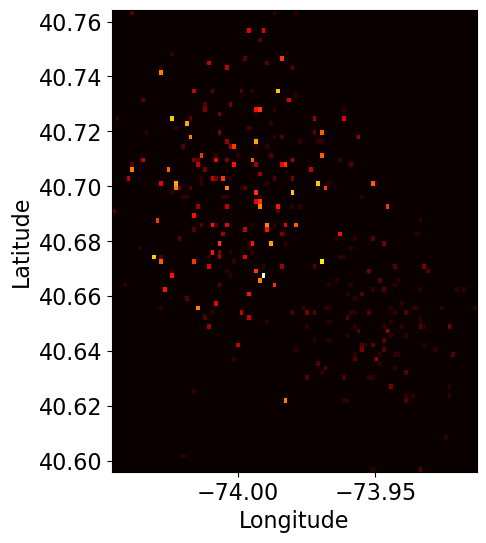

In [4]:
'''
以下是为呈现画图效果和适应编造数据的改版
'''
import numpy as np
import folium
import matplotlib.pyplot as plt
import numpy as np
import random

# 1. 模拟POI的经纬度信息（geo_info）：键为POI ID，值为[纬度, 经度]
# 假设区域为纽约市附近（纬度约40.6~40.9，经度约-74.0~-73.9）
np.random.seed(42)  # 固定随机种子，确保结果可复现
num_pois = 500  # 总POI数量
geo_info = {}
for i in range(num_pois):
    poi_id = f'POI_{i:03d}'  # 生成POI ID（如POI_001）
    # 随机生成经纬度，模拟两个密集区域
    if i < 300:  # 第一个密集区（曼哈顿附近）
        lat = 40.7 + np.random.normal(0, 0.03)  # 纬度围绕40.7波动
        lon = -74.0 + np.random.normal(0, 0.02)  # 经度围绕-74.0波动
    else:  # 第二个密集区（布鲁克林附近）
        lat = 40.65 + np.random.normal(0, 0.02)
        lon = -73.95 + np.random.normal(0, 0.015)
    geo_info[poi_id] = [round(lat, 6), round(lon, 6)]  # 保留6位小数

# 2. 模拟目标POI列表（flattened_list）：从总POI中随机选择，包含重复（模拟多次出现的热门POI）
flattened_list = []
# 第一个密集区的POI被选中概率更高
popular_pois = [f'POI_{i:03d}' for i in range(100)]  # 前100个POI更热门
other_pois = [f'POI_{i:03d}' for i in range(100, num_pois)]
# 生成1000个POI记录，热门POI占比70%
for _ in range(1000):
    if np.random.random() < 0.7:
        flattened_list.append(random.choice(popular_pois))
    else:
        flattened_list.append(random.choice(other_pois))



# 直接使用编造的geo_info和flattened_list（替代文件读取）
# geo_info和flattened_list的定义见上文编造数据部分

# 提取POI的经纬度
poi_data = [geo_info[poi_id] for poi_id in flattened_list]

# 分离纬度和经度
lats = [float(row[0]) for row in poi_data]
lons = [float(row[1]) for row in poi_data]

# 绘制热力图
fig, ax = plt.subplots(figsize=(10, 6))
ax.set_facecolor('black')

# 创建二维直方图（密度热力图）
heatmap, xedges, yedges = np.histogram2d(lons, lats, bins=100)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]

# 绘制热力图（'hot'色系：红色表示高密度，黄色次之，黑色表示低密度）
cax = ax.imshow(heatmap.T, extent=extent, origin='lower', cmap='hot', alpha=1, interpolation='nearest')

# 设置标签和刻度
ax.set_xlabel('Longitude', fontsize=16)
ax.set_ylabel('Latitude', fontsize=16)
ax.tick_params(axis='x', labelsize=16)
ax.tick_params(axis='y', labelsize=16)

# 保存并显示
plt.savefig('FQ0.3FAKE.pdf', format='pdf', bbox_inches='tight')
plt.show()